In [ ]:
# Data pre-processing pipeline + GAN for the KITTI Dataset.
import torch
from torchvision import transforms
import numpy as np
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt
from skimage import io
import random

In [ ]:
from google.colab import drive
drive.mount(r'/content/drive/', force_remount = True) # mounting the drive.

Mounted at /content/drive/


In [ ]:
basePath = r'/content/drive/My Drive/!CIS520_ML_Penn/Dataset/Processed_Data'

In [ ]:
# Some Custom Transformations (adapted code)

import torch
import random
import numpy as np
from PIL import Image

'''Set of tranform random routines that takes list of inputs as arguments,
in order to have random but coherent transformations.'''


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, images):
        for t in self.transforms:
            images = t(images)
        return images


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, images):
        for tensor in images:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.sub_(m).div_(s)
        return images


class ArrayToTensor(object):
    """Converts a list of numpy.ndarray (H x W x C) along with a intrinsics matrix to a list of torch.FloatTensor of shape (C x H x W) with a intrinsics tensor."""

    def __call__(self, images):
        tensors = []
        for im in images:
            # put it from HWC to CHW format
            im = np.transpose(im, (2, 0, 1))
            # handle numpy array
            tensors.append(torch.from_numpy(im).float()/255)
        return tensors

In [ ]:
### Dataloaders using pytorch frameworks
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize

def depthByName(path):
    num = path.split('.jpg')[0].split(os.path.sep)[-1] #int(path.split('.npy')[0].split(os.path.sep)[-1])
    return num

def imageByName(path):
    #print(path.split('.jpg')[0].split(os.path.sep)[-1])
    num = path.split('.jpg')[0].split(os.path.sep)[-1] #int(path.split('.jpg')[0].split(os.path.sep)[-1])
    #print(num)
    return num

def sortPaths(imgPaths, dmapPaths):
    imgPaths = sorted(imgPaths, key = imageByName);
    dmapPaths = sorted(dmapPaths, key = depthByName);
    return imgPaths, dmapPaths

# def validityCheck(iPath, dPath): # checks the validity of the incoming data (checks whether data is pairwise)
#     counter = 0

#     try:
#         assert len(iPath) == len(dPath)
#     except AssertionError:
#         print('Data is not the same length')

#     for m in range(len(iPath)):
#       img_name = iPath[m].split('/')[-1].split('.')[0].split('_')
#       dmap_name = dPath[m].split('/')[-1].split('.')[0].split('_')
      
#       # The names are structured as dir_#_img_# and dir_#_dmap_#
#       # We need to compare the two # strings

#       img_ID = img_name[1] + img_name[3]
#       dmap_ID = dmap_name[1] + dmap_name[3]
      
#       assert(img_ID == dmap_ID)

#       counter += 1

#     print(f'Test Passed : All data is pairwise. Number of Samples tested : {counter}')
#     print('===================================')

def validityCheckPairs(img_dmap_pairs): # checks the validity of the incoming data (checks whether data is pairwise)
    counter = 0

    for pair in img_dmap_pairs:
      img_name = pair[0].split('/')[-1].split('.')[0].split('_')
      dmap_name = pair[1].split('/')[-1].split('.')[0].split('_')
      
      # The names are structured as dir_#_img_# and dir_#_dmap_#
      # We need to compare the two # strings

      img_ID = img_name[1] + img_name[3]
      dmap_ID = dmap_name[1] + dmap_name[3]
      
      assert(img_ID == dmap_ID)

      counter += 1

    print(f'Test Passed : All data is pairwise. Number of Samples tested : {counter}')
    print('===================================')


def buildPairs(imgs, dmaps):
    pairs = []
    for i in imgs:
        img_name = i.split('/')[-1].split('.')[0].split('_')
        dmap_path = basePath + '/dmaps/' + img_name[0] + '_' + img_name[1] + '_' + 'dmap' + '_' + img_name[3] + '.jpg'
        if dmap_path in dmaps:
            pairs.append([i, dmap_path])
    return pairs

def getDataPaths(): # Gets the paths were data is stored.
    Directories = glob(basePath + os.path.sep + '*')

    imgPathsDir = glob(Directories[0] + os.path.sep + '*.jpg');
    dmapPathsDir = glob(Directories[1] + os.path.sep + '*.jpg');
    imgPathsDir, dmapPathsDir = sortPaths(imgPathsDir, dmapPathsDir);
    
    # Figure out which of the two has fewer entries
    # bottleneck = np.argmin([len(imgPathsDir), len(dmapPathsDir)])
    # For now, we know that images has fewer entries than dmaps
    img_dmap_pairs = buildPairs(imgPathsDir, dmapPathsDir)

    validityCheckPairs(img_dmap_pairs)

    random.shuffle(img_dmap_pairs)

    # Check again to be sure
    validityCheckPairs(img_dmap_pairs)

    return img_dmap_pairs

## Image Dataloader
class ImageDataset(Dataset):
   
    def __init__(self,
                 paths,
                 op,
                 transforms=None):
        """      
        Args:
            op (str): "train", "val", or "test" to indicate the split type
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.paths = paths
        self.transform = transforms
        self.op = op

        self.num_ex = len(paths)

        try:
            if self.op == 'train':
                self.split_paths = self.paths[0:int(0.6*self.num_ex)]
            elif self.op == 'val':
                self.split_paths = self.paths[int(0.6*self.num_ex):int(0.8*self.num_ex)]
            elif self.op == 'test':
                self.split_paths = self.paths[int(0.8*self.num_ex):int(self.num_ex)]

        except ValueError:
            print('op is not train, val, or test')

    def __len__(self):
        return len(self.split_paths)

    def __getitem__(self, idx):
        img = io.imread(self.split_paths[idx][0])
        dmap = io.imread(self.split_paths[idx][1])

        img = resize(img, (img.shape[0] // 2, img.shape[1] // 2),
                       anti_aliasing=True)
        dmap = resize(dmap, (dmap.shape[0] // 2, dmap.shape[1] // 2),
                       anti_aliasing=True)

        if self.transform:
          img, dmap = self.img_transform(img, dmap)

        sample = {'img': img, 'dmap': dmap}
        return sample

    def img_transform(self, img, dmap):
        ## Apply Transformations
        img = self.transform(img)
        dmap = self.transform(dmap)
        return img, dmap

In [ ]:
data_paths = getDataPaths()

Test Passed : All data is pairwise. Number of Samples tested : 3824
Test Passed : All data is pairwise. Number of Samples tested : 3824


Test Passed : All data is pairwise. Number of Samples tested : 3824
Test Passed : All data is pairwise. Number of Samples tested : 3824
2294
765
765
torch.Size([16, 128, 416, 3])


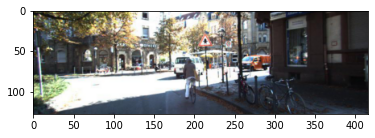

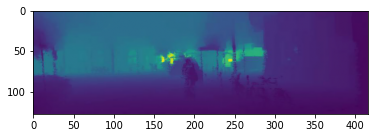

In [ ]:
data_paths = getDataPaths()
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = ImageDataset(data_paths, op="train", transforms=img_transform)
val_dataset = ImageDataset(data_paths, op="val", transforms=img_transform)
test_dataset = ImageDataset(data_paths, op="test", transforms=img_transform)

print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

train_batch_size = 16
val_batch_size = 16
test_batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_dataset_notensor = ImageDataset(data_paths, op="train", transforms=None)
train_dataloader_notensor = DataLoader(train_dataset_notensor, batch_size=train_batch_size, shuffle=False)

# Load some image and view them
for data in train_dataloader_notensor:
  plt.figure()
  plt.imshow(data['img'][0])
  plt.figure()
  plt.imshow(data['dmap'][0])
  print(data['img'].shape)

  break

In [ ]:
### UNET FROM https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        #self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        out = self.conv(dec1)
        #out = self.relu(out)
        out = torch.sigmoid(out)
        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
model = UNet()
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
## Initialize Optimizer and Learning Rate Scheduler
learning_rate = 1e-5
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_metric = torch.nn.MSELoss() # For regression task

if torch.cuda.is_available():
    gpu_boole = True
else:
    gpu_boole = False
print(gpu_boole)

if gpu_boole:
    model = model.cuda()
    loss_metric = loss_metric.cuda()

True


In [ ]:
loss_train_epochs = []
loss_train_batch = []
loss_val_epochs = []
loss_val_batch = []

train_pred_sample = []
train_truth_sample = []
val_pred_sample = []
val_truth_sample = []

for epoch in range(num_epochs):
    ########################### Training #####################################
    for batch in train_dataloader:
        x = batch["img"]
        y = batch["dmap"]
        if gpu_boole:
            x = x.cuda().float()
            y = y.cuda().float()

        if epoch > 0:
            optimizer.zero_grad()

        outputs = model.forward(x)
        loss = loss_metric(outputs, y)
        loss.backward()
        ##performing update:
        optimizer.step()

        ##record training loss per batch:
        training_loss = loss.cpu().data.numpy().item()
        loss_train_batch.append(training_loss)

    ##record training final training loss within the epoch:
    loss_train_epochs.append(training_loss)

    if (epoch == 0) or (epoch == 4) or (epoch == num_epochs-1):
      train_pred_sample.append(outputs[0])
      train_truth_sample.append(y[0])
    print("Train Epoch Sample grabbed")

    ########################### Validation #####################################
    # Only record the validation loss
    for batch in validation_dataloader:
        x = batch["img"]
        y = batch["dmap"]
        if gpu_boole:
            x = x.cuda().float()
            y = y.cuda().float()
            
        outputs = model.forward(x)
        loss = loss_metric(outputs, y)

        validation_loss = loss.cpu().data.numpy().item()
        loss_val_batch.append(validation_loss)

    ##record validation loss:
    loss_val_epochs.append(validation_loss)
    if (epoch == 0) or (epoch == 4) or (epoch == num_epochs-1):
      val_pred_sample.append(outputs[0])
      val_truth_sample.append(y[0])
    print("Val Epoch Sample grabbed")



    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    print("Training loss: ", training_loss)
    print("Validation loss: ", validation_loss)

Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 1 of 10

Training loss:  0.04488053917884827
Validation loss:  0.04192589223384857
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 2 of 10

Training loss:  0.04273642227053642
Validation loss:  0.04005901515483856
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 3 of 10

Training loss:  0.04209547117352486
Validation loss:  0.0393737331032753
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 4 of 10

Training loss:  0.04122389107942581
Validation loss:  0.03849676623940468
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 5 of 10

Training loss:  0.0401696041226387
Validation loss:  0.03751083090901375
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 6 of 10

Training loss:  0.03909103944897652
Validation loss:  0.03658514469861984
Train Epoch Sample grabbed
Val Epoch Sample grabbed

EPOCH 7 of 10

Training loss:  0.03798375278711319
Validation loss:  0.03558078035712242
Train Ep

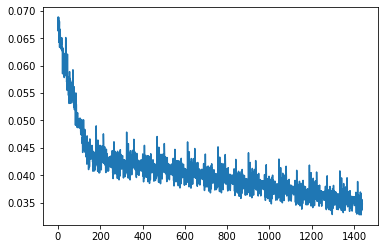

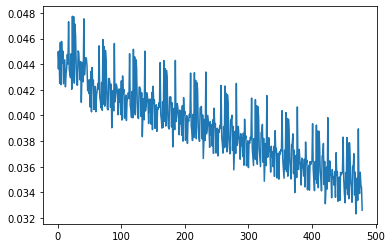

In [ ]:
plt.plot(loss_train_batch)
plt.figure()
plt.plot(loss_val_batch)

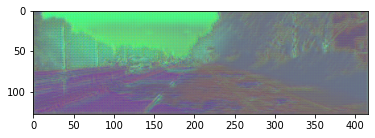

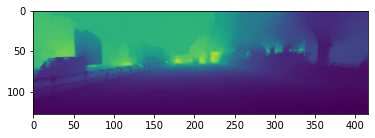

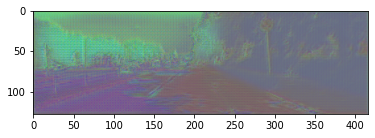

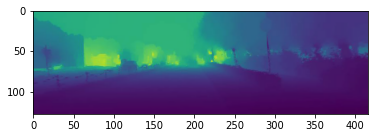

In [ ]:
plt.figure()
plt.imshow(train_pred_sample[0].permute(1, 2, 0).cpu().detach().numpy())


plt.figure()
plt.imshow(train_truth_sample[0].permute(1, 2, 0).cpu().detach().numpy())

plt.figure()
plt.imshow(val_pred_sample[0].permute(1, 2, 0).cpu().detach().numpy())
plt.figure()
plt.imshow(val_truth_sample[0].permute(1, 2, 0).cpu().detach().numpy())


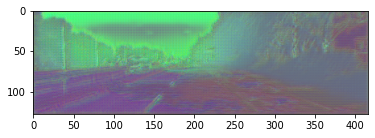

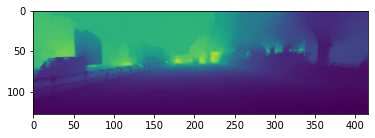

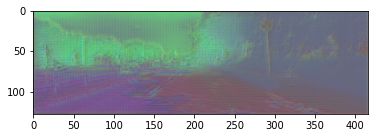

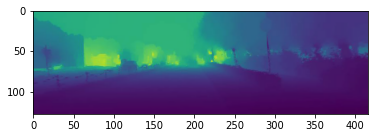

In [ ]:
plt.figure()
plt.imshow(train_pred_sample[1].permute(1, 2, 0).cpu().detach().numpy())


plt.figure()
plt.imshow(train_truth_sample[1].permute(1, 2, 0).cpu().detach().numpy())

plt.figure()
plt.imshow(val_pred_sample[1].permute(1, 2, 0).cpu().detach().numpy())
plt.figure()
plt.imshow(val_truth_sample[1].permute(1, 2, 0).cpu().detach().numpy())


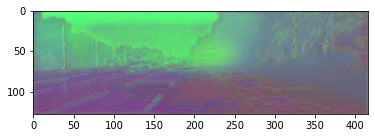

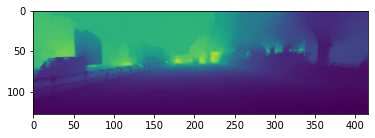

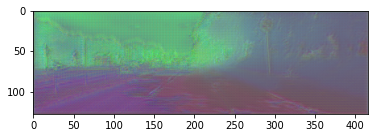

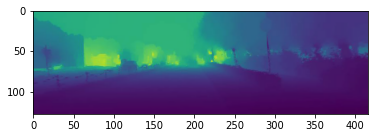

In [ ]:

plt.figure()
plt.imshow(train_pred_sample[2].permute(1, 2, 0).cpu().detach().numpy())


plt.figure()
plt.imshow(train_truth_sample[2].permute(1, 2, 0).cpu().detach().numpy())

plt.figure()
plt.imshow(val_pred_sample[2].permute(1, 2, 0).cpu().detach().numpy())
plt.figure()
plt.imshow(val_truth_sample[2].permute(1, 2, 0).cpu().detach().numpy())


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/!CIS520_ML_Penn/depth_unet.model')

# Testing Set

Load the saved model, and observe the testing set performance

In [ ]:
model = UNet()
model.load_state_dict(torch.load('/content/drive/My Drive/!CIS520_ML_Penn/depth_unet.model'))

<All keys matched successfully>

In [ ]:
train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
if torch.cuda.is_available():
    gpu_boole = True
else:
    gpu_boole = False
print(gpu_boole)

loss_metric = torch.nn.MSELoss() # For regression task

if gpu_boole:
    model = model.cuda()
    loss_metric = loss_metric.cuda()

True


In [ ]:
for batch in test_dataloader:
    x = batch["img"]
    y = batch["dmap"]
    if gpu_boole:
        x = x.cuda().float()
        y = y.cuda().float()

    outputs = model.forward(x)
    loss = loss_metric(outputs, y)

In [ ]:
print(loss.cpu().item())

0.040846243500709534


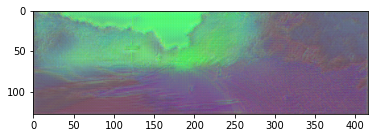

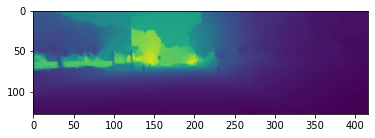

In [ ]:
plt.figure()
plt.imshow(outputs[0].permute(1, 2, 0).cpu().detach().numpy())


plt.figure()
plt.imshow(y[0].permute(1, 2, 0).cpu().detach().numpy())